# Global Attention-augmented Quantum Conditioning (AAQC)
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal
from IPython.display import SVG, display

# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 10000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"
TIMESTAMP = time.strftime("%d%m%Y_%H")

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 32
Bits per Token: 5
Max Sequence Length: 34
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=PH1]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---

def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (6623, 37)
X_bits shape: (6623, 33, 5)
Props shape: (6623, 3)
Y_ind shape: (6623, 33)
------------------------------
Loaded validation data:
Dataset loaded with shape: (1419, 37)
X_bits shape: (1419, 33, 5)
Props shape: (1419, 3)
Y_ind shape: (1419, 33)
------------------------------
Loaded validation data:
Dataset loaded with shape: (1420, 37)
X_bits shape: (1420, 33, 5)
Props shape: (1420, 3)
Y_ind shape: (1420, 33)


## Quantum Circuit

### Attention Computation

The model utilizes a classical attention mechanism to maintain context over the sequence generation.

In [7]:
def batched_causal_attention(Q, K, V, mask_value=-1e9):
    """
    Computes attention for the whole batch (B, L, E) at once.
    Args:
        Q: Query matrix, shape (B, L, E)
        K: Key matrix, shape (B, L, E)
        V: Value matrix, shape (B, L, E)
        mask_value: Value to use for masked positions (default: -1e9)
    Returns:
        Output matrix after attention, shape (B, L, E)
    """
    d_k = Q.shape[-1] 
    
    # Transpose last two dimensions of K for matrix multiplication
    K_swap = K.swapaxes(-1, -2)  # (B, E, L)

    # Calculate scores: (B, L, E) @ (B, E, L) -> (B, L, L)
    scores = jnp.matmul(Q, K_swap) / jnp.sqrt(d_k)
    
    # Create Mask (Triangular): 1s in the lower triangle, 0s in upper
    L = Q.shape[1]
    causal_mask = jnp.tril(jnp.ones((L, L)))
    
    # Apply mask: Where mask is 0 (future), set score to -infinity
    scores = jnp.where(causal_mask == 1, scores, mask_value)
    
    # Softmax to get weights (probabilities)
    weights = jax.nn.softmax(scores, axis=-1)

    # Multiplies the attention probabilities by the Value matrix V
    output = jnp.matmul(weights, V) # (B, L, E)
    return output

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Encoding ($R_x$).
3.  **Context Vector:** Encoded via $R_y$ rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\sigma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.

In [8]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [9]:
# Circuit parameters -------------------------------------------------------------------
N_LAYERS = 8  # number of variational layers
H_LOCAL = 3 # h_local sets the maximum number of qubits that interact in the Z terms
# --------------------------------------------------------------------------------------

# Qubit initialization
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
tw_aw = token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)

def molecular_property_encoder(props):
    """Encode continuous props on property qubits via RY rotations"""
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])

def conditional_injection(gamma):
    """Property injection via controlled RX gates"""
    param_idx = 0
    for prop_w in prop_wires:
        for token_w in token_wires:
            qml.CRX(gamma[param_idx], wires=[prop_w, token_w])
            param_idx += 1


def entangling_layer(theta):    
    # Rotations RX, RY, RZ
    target_wires = token_wires + ancilla_wires
    
    for i, wire in enumerate(target_wires):
        qml.RX(theta[i, 0], wires=wire)
        qml.RY(theta[i, 1], wires=wire)
        qml.RZ(theta[i, 2], wires=wire)
    
    # CNOT Ring
    for i in range(len(tw_aw)):
        qml.CNOT(wires=[tw_aw[i], tw_aw[(i+1) % len(tw_aw)]])


def hamiltonian_layer(sigma, time=1.0, combos=None):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    if combos is None:
        combos = zstring_combos(tw_aw)

    # Safety: ensure the vector length matches the number of combos
    assert sigma.shape[0] == len(combos), \
        f"sigma has length {sigma.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * sigma * time
    for sigma, combo in zip(sigma, combos):
        qml.MultiRZ(-2.0 * sigma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta, gamma, sigma, attention_context):
    """
    QNode for the autoregressive model.
    Args:
        token_bits: Bit representation of input tokens (shape: BITS_PER_TOKEN,)
        props: Molecular properties (shape: 3,)
        theta: Variational parameters for operator layers (shape: N_LAYERS, n_token_ancilla, 3)
        gamma: Property entanglement parameters (shape: N_LAYERS, n_prop_qubits, n_token_ancilla, 2)
        sigma: Parameters for Sigma layers (shape: N_LAYERS, num_zstrings)
    Returns:
        Probabilities over token qubits.
    """
    # Encode tokens and properties
    token_encoder(token_bits)               # Basis-encode token bits
    molecular_property_encoder(props)       # Encode molecular properties
    combos = zstring_combos(tw_aw)          # Precompute Z-string combos

    # Encode attention context on token qubits
    for i, val in enumerate(attention_context):
        qml.RY(val, wires=token_wires[i])

    for l in range(N_LAYERS):
         # Property Injection (CRX)
        conditional_injection(gamma[l])
        
        # Entangling Layer U_mix(θ)
        entangling_layer(theta[l])

        # Diagonal Hamiltonian U(σ)
        hamiltonian_layer(sigma[l], time=1.0, combos=combos)

    return qml.probs(wires=token_wires)

In [10]:
@jax.jit
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    """
    Pure inference step for validation (No Gradients).
    """
    # 1. Embedding & Positional Encoding (Same as training)
    x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
    input_embeddings = params['embedding_table'][x_indices]
    
    L = input_embeddings.shape[1]
    positions = jnp.arange(L)[None, :]
    dim_indices = jnp.arange(EMBEDDING_SIZE)
    exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
    denom = 10000 ** exponent
    angles = positions[..., None] / denom
    pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
    x_i_pos = input_embeddings + pos_enc

    # 2. Projections & Attention
    Q = x_i_pos @ params['W_Q']
    K = x_i_pos @ params['W_K']
    V = x_i_pos @ params['W_V']
    output_context = batched_causal_attention(Q, K, V)

    # 3. Quantum Model Prediction
    pred_probs = batch_predict(
        params, x_bits_batch, prop_batch, output_context
    )

    # 4. Metrics
    loss, _ = total_loss_fn(pred_probs, y_target_indices)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

### Loss Function

**Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).


In [11]:
def total_loss_fn(pred_probs, target_indices, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
        
    # 1. Get dimensions
    vocab_size = pred_probs.shape[-1] 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # 6. Normalize
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    max_loss_scale = jnp.log(vocab_size)
    normalized_loss = mean_ce / max_loss_scale
    
    return normalized_loss, mean_ce

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [12]:
# ----- Configuration & Shapes -----
n_token_ancilla = BITS_PER_TOKEN + n_ancillas
n_dense_connections = n_prop_qubits * BITS_PER_TOKEN

# Precompute Z-string combos once
combos = zstring_combos(tw_aw)
n_combos = len(combos)

# ----- Build Params -----
key = jax.random.PRNGKey(42)

# Token embeddings
EMBEDDING_SIZE = BITS_PER_TOKEN + n_ancillas
key, k_emb = jax.random.split(key)
embedding_table = jax.random.normal(k_emb, (VOCABULARY_SIZE, EMBEDDING_SIZE)) * 0.1

# Attention Projections
proj_dim = BITS_PER_TOKEN
key, k_WQ, k_WK, k_WV = jax.random.split(key, 4)
W_Q = jax.random.normal(k_WQ, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_K = jax.random.normal(k_WK, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_V = jax.random.normal(k_WV, (EMBEDDING_SIZE, proj_dim)) * 0.1

# Quantum Circuit Parameters
key, k_theta, k_gamma, k_sigma = jax.random.split(key, 4)

combined_params = {
    # Quantum
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'gamma': jax.random.normal(k_gamma, (N_LAYERS, n_dense_connections)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_combos)) * 0.01,
    # Classical
    'embedding_table': embedding_table,
    'W_Q': W_Q,
    'W_K': W_K,
    'W_V': W_V
}

BATCH_SIZE = 16
STEPS_PER_EPOCH = N_MOLECS // BATCH_SIZE
N_EPOCHS = 100

# Warmup + Cosine Decay Schedule
# Start at 0.0, go up to 0.001 in 10 epochs, then decay
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,              # Start from zero to stabilize gradients
    peak_value=0.001,            # Reduced from 0.005 to 0.001
    warmup_steps=10 * STEPS_PER_EPOCH,  # Warmup for first 10 epochs
    decay_steps=N_EPOCHS * STEPS_PER_EPOCH,
    end_value=0.0001             # Decay to a small non-zero value
)

optimizer = optax.adamw(learning_rate=schedule, weight_decay=1e-2)

opt_state = optimizer.init(combined_params)

In [13]:
def single_step_prediction(params, x_token_bits, x_props, context_vec):
    """
    Executes the quantum model for a SINGLE token of a SINGLE molecule.
    Args:
        params: Dictionary of model parameters.
        x_token_bits: Bit representation of the current token (shape: BITS_PER_TOKEN,).
        x_props: Molecular properties (shape: 3,).
        context_vec: Attention context vector (shape: BITS_PER_TOKEN,).
    Returns:
        Tuple of:
            - Probabilities over token qubits (shape: VOCABULARY_SIZE,).
            - Expectation values of property qubits (shape: 3,).
    """
    theta = params['theta']
    gamma = params['gamma']
    sigma = params['sigma']
    
    # Call Quantum Node
    return autoregressive_model(
        x_token_bits, x_props, theta, gamma, sigma, context_vec
    )

# Vectorize from single input to sequence and batch inputs
sequence_predict = jax.vmap(
    single_step_prediction, 
    in_axes=(None, 0, None, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: None     -> same props for all tokens
    # context_vec: 0    -> different context per token
)

batch_predict = jax.vmap(
    sequence_predict, 
    in_axes=(None, 0, 0, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: 0        -> different props per molecule
    # context_vec: 0    -> different context per token
)

In [14]:
@jax.jit
def training_step_batched(params, opt_state, x_bits_batch, prop_batch, y_target_indices, alpha=0.5):
    """
    Performs a single training step over a batch of data.
    Args:
        params: Model parameters
        opt_state: Optimizer state
        x_bits_batch: Input bits batch (B, L, 5)
        prop_batch: Molecular properties batch (B, 3)
        y_target_indices: Target token indices batch (B, L)
        alpha: Weight for property loss

    Returns:
        new_params: Uptimed model parameters
        loss: Computed loss for the batch
        opt_state: Uptimed optimizer state
        grads: Computed gradients
        acc: Accuracy for the batch
    """
    def loss_fn(params):
        # 1.1. Embedding table lookup
        x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
        input_embeddings = params['embedding_table'][x_indices]
        
        # 1.2. Calculate Positional Encoding (Sinusoidal)
        L = input_embeddings.shape[1]               # Sequence Length

        positions = jnp.arange(L)[None, :]          # Indexes over Length dimension
        dim_indices = jnp.arange(EMBEDDING_SIZE)    # Dimension indices for embedding

        exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
        denom = 10000 ** exponent                   # Calculate the frequency denominator

        angles = positions[..., None] / denom       # Calculate angles of PE

        # Apply sine for even indices (2i) and cosine for odd indices (2i+1) 
        pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
        x_i_pos = input_embeddings + pos_enc

        # 1.3. Compute Q, K, V matrices
        Q = x_i_pos @ params['W_Q']
        K = x_i_pos @ params['W_K']
        V = x_i_pos @ params['W_V']

        # 1.4. Compute (Batched) Attention
        output_context = batched_causal_attention(Q, K, V)

        # 1.5. Quantum Model Prediction
        pred_probs = batch_predict(
            params, x_bits_batch, prop_batch, output_context
        )

        # 1.6. Compute Loss
        final_loss, token_loss = total_loss_fn(
            pred_probs,
            y_target_indices, 
        )
        
        return final_loss, (token_loss, pred_probs)

    # 1. Calculate loss and gradients
    (loss, (token_loss, pred_probs)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # 2. Uptime parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # 3. Compute accuracy
    acc = compute_accuracy_masked(pred_probs, y_target_indices)

    return new_params, loss, opt_state, grads, acc, token_loss

In [15]:
print(f"Starting training with {N_MOLECS} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# Create directory for checkpoints if it doesn't exist
ckpt_dir = '../data/params/'
os.makedirs(ckpt_dir, exist_ok=True)

key = random.PRNGKey(42)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

token_loss_history = []

best_val_loss = float('inf')

# Training + Validation loop
for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch

    # ------ Training Phase ------
    total_loss = 0.0
    total_acc = 0.0

    total_token_loss = 0.0
    
    # Shuffle data at the start of each epoch to improve generalization
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_MOLECS)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]
    
    for step in range(0, N_MOLECS, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_MOLECS)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc, token_loss = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)

        total_token_loss += token_loss * batch_n

    # Average metrics over epoch
    avg_loss = total_loss / N_MOLECS
    avg_acc = total_acc / N_MOLECS

    loss_history.append(float(avg_loss))
    acc_history.append(float(avg_acc))

    token_loss_history.append(float(total_token_loss / N_MOLECS))
    # ------ Validation Phase ------
    val_total_loss = 0.0
    val_total_acc = 0.0
    N_VAL = len(X_bits_val)
    
    # Iterate through Validation Data
    for v_step in range(0, N_VAL, BATCH_SIZE):
        v_idx_end = min(v_step + BATCH_SIZE, N_VAL)
        
        vx_batch = X_bits_val[v_step:v_idx_end]
        vp_batch = Props_val[v_step:v_idx_end]
        vy_batch = Y_ind_val[v_step:v_idx_end]
        
        if len(vx_batch) == 0: continue

        # Pure Inference (No optimizer uptime, no gradients)
        v_loss, v_acc = validation_step_batched(
            combined_params, 
            vx_batch, 
            vp_batch, 
            vy_batch
        )
        
        v_batch_n = len(vx_batch)
        val_total_loss += v_loss * v_batch_n
        val_total_acc += v_acc * v_batch_n

    val_avg_loss = val_total_loss / N_VAL
    val_avg_acc = val_total_acc / N_VAL
    val_loss_history.append(float(val_avg_loss))
    val_acc_history.append(float(val_avg_acc))

    epoch_time = time.time() - epoch_start_time

    # Print both Train and Val metrics
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_avg_loss:.4f} | Val Acc: {val_avg_acc:.4f} | Time: {epoch_time:.2f}s")
    print(f"           | Token Loss: {token_loss_history[-1]:.4f}")

    # Checkpointing (Save Best Model)
    if epoch > 40 and val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        
        # Save with a specific name indicating it is the "best"
        save_path = os.path.join(ckpt_dir, f"attention_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl")
        
        with open(save_path, "wb") as f:
            pickle.dump(combined_params, f)

Starting training with 10000 molecules.
Batch Size: 16 | Steps per epoch: 625
Epoch 001 | Train Loss: 1.2427 | Train Acc: 0.0269 | Val Loss: 1.1177 | Val Acc: 0.0175 | Time: 1480.73s
           | Token Loss: 4.3067
Epoch 002 | Train Loss: 0.9178 | Train Acc: 0.1097 | Val Loss: 0.8817 | Val Acc: 0.1255 | Time: 1368.93s
           | Token Loss: 3.1807
Epoch 003 | Train Loss: 0.7612 | Train Acc: 0.3318 | Val Loss: 0.7960 | Val Acc: 0.2771 | Time: 1384.55s
           | Token Loss: 2.6380
Epoch 004 | Train Loss: 0.7005 | Train Acc: 0.4491 | Val Loss: 0.7526 | Val Acc: 0.3553 | Time: 1377.55s
           | Token Loss: 2.4279
Epoch 005 | Train Loss: 0.6622 | Train Acc: 0.4912 | Val Loss: 0.7227 | Val Acc: 0.3779 | Time: 1383.47s
           | Token Loss: 2.2951
Epoch 006 | Train Loss: 0.6368 | Train Acc: 0.5020 | Val Loss: 0.7045 | Val Acc: 0.3866 | Time: 1386.18s
           | Token Loss: 2.2069
Epoch 007 | Train Loss: 0.6219 | Train Acc: 0.5175 | Val Loss: 0.6936 | Val Acc: 0.3990 | Time: 1420

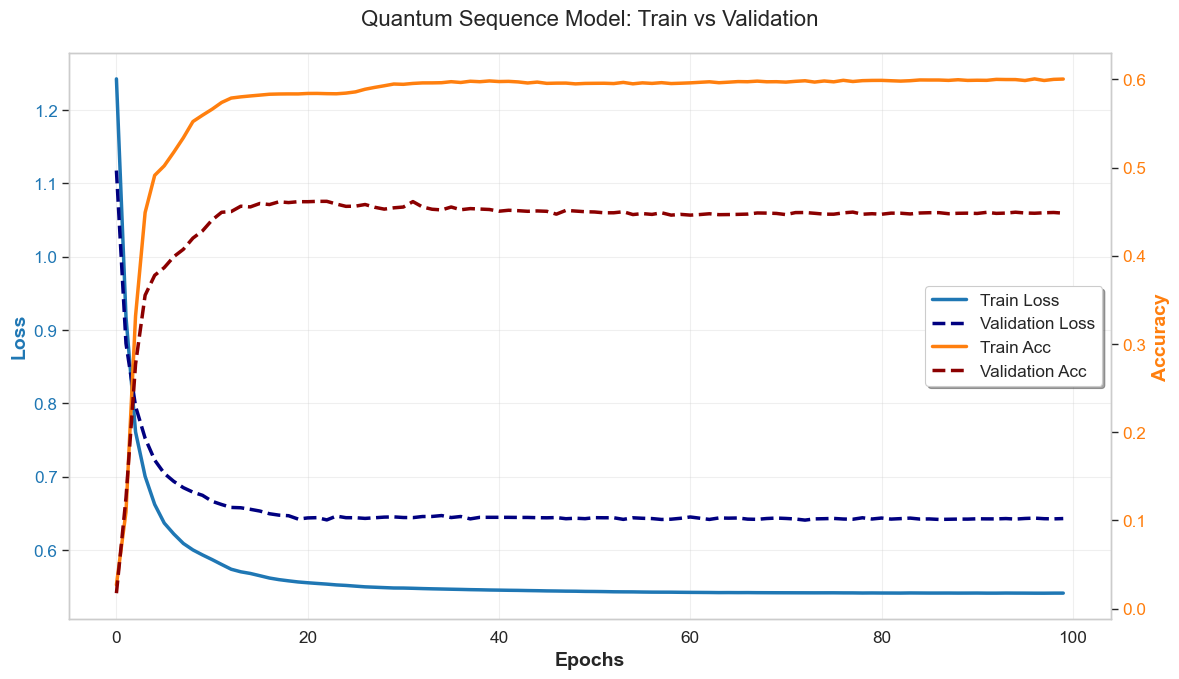

In [16]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(loss_history, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_history, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')

ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(acc_history, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_history, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()

plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

**Objective:** To report the true generalization performance of the model on unseen data.

**Process:**
1.  **Load Best Model:** We load the model parameters that achieved the lowest validation loss.
2.  **Conditioned Generation:** For each set of molecular properties (LogP, QED, MW) in the Test Set, we generate a new molecule.
3.  **Metric Calculation:** We compute standard generative metrics:
    * **Validity:** Percentage of generated sequences that decode to valid chemical structures.
    * **Uniqueness:** Percentage of valid molecules that are unique.
    * **Novelty:** Percentage of valid molecules that do not appear in the Training Set.

In [21]:
# Load best model parameters
with open(os.path.join(ckpt_dir, f"attention_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl"), "rb") as f:
    combined_params = pickle.load(f)

In [22]:
def molecule_stochastic_generation(key, props, combined_params, temperature=0.7):
    """
    Generate a molecule in SELFIES format using the trained model.
    Args:
        key: JAX PRNGKey for randomness.
        props: Molecular properties (shape: 3,).
        combined_params: Dictionary of trained model parameters.
        temperature: Sampling temperature for diversity.
    Returns:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,).
    """
    embedding_table = combined_params['embedding_table']
    W_Q = combined_params['W_Q']
    W_K = combined_params['W_K']
    W_V = combined_params['W_V']
    theta = combined_params['theta']
    gamma = combined_params['gamma']
    sigma_params = combined_params['sigma']
    
    generated_bits = []
    
    # Store the projected Keys and Values for history
    past_Ks = []
    past_Vs = []
    
    current_token_index = SOS_index
    current_token_bits = jnp.array(list(map(int, format(SOS_index, f'0{BITS_PER_TOKEN}b'))), dtype=jnp.int32)
    local_rng = key 
    
    for t in range(MAX_LEN):
        local_rng, subkey = random.split(local_rng)

        # 1. Embedding & Position Encoding (Same as Training)
        x_token = current_token_bits 
        current_token_index = bits_to_index(x_token)
        x_i = embedding_table[current_token_index]

        # Position matches 't' because we are at the t-th step of the sequence
        position = t
        dim_indices = jnp.arange(EMBEDDING_SIZE)
        positional_encoding = jnp.where(
            dim_indices % 2 == 0,
            jnp.sin(position / (10000 ** (dim_indices / EMBEDDING_SIZE))),
            jnp.cos(position / (10000 ** ((dim_indices-1) / EMBEDDING_SIZE)))
        )
        x_i_pos = x_i + positional_encoding

        # 2. Projections
        Q_i = x_i_pos @ W_Q
        K_i = x_i_pos @ W_K
        V_i = x_i_pos @ W_V
        
        # 3. Uptime History 
        # Add current K_i and V_i to history BEFORE computing attention
        past_Ks.append(K_i)
        past_Vs.append(V_i)

        # Attention Calculation
        # Stack lists into arrays for matrix multiplication
        # K_mat shape: (t+1, proj_dim)
        K_mat = jnp.stack(past_Ks)
        V_mat = jnp.stack(past_Vs)
        
        d_k = W_Q.shape[-1]
        
        # Calculate scores against ALL tokens seen so far (including current)
        # Q_i (dim) @ K_mat.T (dim, t+1) -> (t+1) scores
        scores = jnp.matmul(Q_i, K_mat.T) / jnp.sqrt(d_k)
        weights = jnn.softmax(scores)
        
        # Context vector
        output_i = jnp.dot(weights, V_mat)

        # 5. Prediction (Quantum Model)
        pred_probs = autoregressive_model(x_token, props, theta, gamma, sigma_params, output_i)
        
        # 6. Tempering & Sampling
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)

        logit_mask = jnp.zeros((VOCABULARY_SIZE,))
        logit_mask = logit_mask.at[PAD_index].set(-1e9)
        logit_mask = logit_mask.at[SOS_index].set(-1e9)
        
        masked_logits = logits + logit_mask
        tempered_logits = masked_logits / temperature
        tempered_probs = jnn.softmax(tempered_logits)
        
        token_indices = jnp.arange(VOCABULARY_SIZE)
        next_index = random.choice(subkey, token_indices, p=tempered_probs)

        next_bits_str = format(int(next_index), f'0{BITS_PER_TOKEN}b')
        next_bits = jnp.array([int(b) for b in next_bits_str], dtype=jnp.int32)

        if int(next_index) == EOS_index:
            break

        generated_bits.append(next_bits)
        
        # Uptime for next iteration
        current_token_bits = next_bits 

    return generated_bits


def bits_to_selfies_smiles(generated_bits):
    """
    Convert a list of bit arrays to SELFIES string and SMILES string.
    Args:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,)
    Returns:
        Tuple of:
            - selfies_str: Generated SELFIES string
            - smiles_str: Decoded SMILES string (or None if decoding fails)
    """
    selfies_tokens = []
    for bits in generated_bits:
        index = int("".join(map(str, bits)), 2)
        
        if index >= VOCABULARY_SIZE:
            break

        token = ALPHABET[int(index)]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except:
        smiles_str = None
    return selfies_str, smiles_str

In [23]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles


def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score


def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score



def load_training_smiles_for_novelty(train_csv_path):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # --- FIX: Read everything as string to preserve "00000" format ---
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            # Handle potential NaNs from string conversion
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                idx = int(bit_str, 2)
                
                if idx < len(ALPHABET):
                    token = ALPHABET[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue # Skip malformed bits
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

In [24]:
# Load Reference Data
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")


print("Starting Generation...")
start_time = time.time()

generated_smiles_list = []
target_props_list = []

# JAX Random Key
key = jax.random.PRNGKey(int(time.time()))

# Loop through the Test Set
# Generate 1 molecule for every row in the test set, using THAT row's properties
for i, row in test_df.iterrows():
    
    # 1. Get Properties from Test Data
    props = jnp.array([row['logP'], row['qed'], row['mw']], dtype=jnp.float32)
    
    # 2. Split Key for randomness
    key, subkey = jax.random.split(key)
    
    # 3. Generate molecule using the BEST parameters loaded
    gen_bits = molecule_stochastic_generation(
        subkey, 
        props, 
        combined_params, 
        temperature=0.7)
    
    # 4. Decode to SMILES
    _, gen_smi = bits_to_selfies_smiles(gen_bits)
    
    generated_smiles_list.append(gen_smi)
    target_props_list.append(props)

    if i % 50 == 0:
        print(f"Generated {i}/{len(test_df)}")


print(f"Generation finished in {time.time() - start_time:.2f}s")


Loading Training Data for Novelty check: ../data/structured_data_selfies_10000_train.csv
Found 6289 unique molecules in Training Set.
Loaded Test Data: 1420 samples
Starting Generation...
Generated 0/1420
Generated 50/1420
Generated 100/1420
Generated 150/1420
Generated 200/1420
Generated 250/1420
Generated 300/1420
Generated 350/1420
Generated 400/1420
Generated 450/1420
Generated 500/1420
Generated 550/1420
Generated 600/1420
Generated 650/1420
Generated 700/1420
Generated 750/1420
Generated 800/1420
Generated 850/1420
Generated 900/1420
Generated 950/1420
Generated 1000/1420
Generated 1050/1420
Generated 1100/1420
Generated 1150/1420
Generated 1200/1420
Generated 1250/1420
Generated 1300/1420
Generated 1350/1420
Generated 1400/1420
Generation finished in 13508.07s


In [25]:
def plot_property_distributions(combined_df):
    """
    Plots the distribution of properties for Generated vs Test Set molecules.
    """
    # Set style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    properties = ['LogP', 'QED', 'MW']
    colors = {'Target Properties': 'grey', 'Generated Properties': 'tab:blue'}
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        
        # Plot KDE (Kernel Density Estimate)
        sns.kdeplot(
            data=combined_df, 
            x=prop, 
            hue='Source', 
            fill=True, 
            common_norm=False, 
            palette=colors,
            alpha=0.3, 
            linewidth=2.5,
            ax=ax
        )
        
        ax.set_title(f'{prop} Distribution', fontweight='bold')
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        
    plt.tight_layout()
    plt.show()


In [26]:
# ------ Calculate Metrics ------

# Validity
val_score, valid_mols = calculate_validity(generated_smiles_list)

# Uniqueness (Calculated only on valid molecules)
uniq_score = calculate_uniqueness(valid_mols)

# Novelty (Calculated only on valid molecules vs Training Set)
nov_score = calculate_novelty(valid_mols, training_set_smiles)

print(f"Number of generated samples: {len(generated_smiles_list)}")
print(f"Validity:   {val_score:.2%}  ({len(valid_mols)} valid)")
print(f"Uniqueness: {uniq_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")

Number of generated samples: 1420
Validity:   99.93%  (1419 valid)
Uniqueness: 93.66%
Novelty:    99.93%


------- Temperature = 0.9

Number of generated samples: 1420
Validity:   97.82%  (1389 valid)
Uniqueness: 78.19%
Novelty:    99.93%
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors

In [27]:
print(generated_smiles_list)

['CC=CC#C[PH1]1O[NH1]OCCCN=NC[NH1]C(=P1)NI', 'C[H]', 'CC(C(Cl)CCCNCC1OC)CC1OC=S#N', 'C1C(C)C1', 'CCCCCCCCCCCCCBr', 'CC=C=NC=CNC=CCCOC1=C[NH1]C=N1', 'CCNCC(C)C#C', 'CC(C)(O)N=CC=C1CC=CC1C', 'CC=NC(C)CCCCl', 'CC(C)F', 'CC(C)CCC(C)C1CCCC1CCCCl', 'CC(C)(C)F', 'CC(C)CCCCCO[PH1]OS1=C[NH1]CC1C[PH1]NOC', 'O1CCCC(C)CCC(O)CC=C1', 'CCCCOCCN(C)CCCNCO', 'C1C=CC1(CCCCOCCCCN=C)CC', 'C123C(C)C=CC=C1CCNC=CC=CC=NC=CC=CC2N3', 'O1C(C)(C)NC=P(=C)C=N1', 'CCBr', 'PNCC(C)C=C[NH1]C=CS1C=CC=N1', 'CC(C1)CC(C)OOCCC=C1C=O', 'C123CC=C(C)C1C(C)C=C2C3Cl', 'N1C=C1C(C)=C[NH1]CCCC', 'CC(C)(C)CCCCCOC=N', 'OCOO', 'CC=N[NH1]C(C)CCCOCCCBr', 'C(=COP)(C)CONC(C)CCCOOC=O', 'CC(C)C(C)CCCCC=O', 'O=C(C)CCCCC=CI', '[H]CI', 'C=CCCCCCCNCOCC=NC=N[H]', 'CC(C)C=[PH1]=[PH1]=S(C)CCOC=SOI', 'NC=CC=CCCC(C)CCCC1CCOC1Cl', 'CC(C)(C)CCONOCP(OCCCN=C)[PH1]CN=NOBr', 'CC(C=COC1CBr)=NN1C', 'CC(C)CCCCNOC=CC1=C[NH1]C=N1', 'CC=CCC=CC=CCC=C[NH1]C=CCC=C[NH1]C=N', 'CCCCC=CSNCCCCN=CC(C)([NH1])ON=O', 'C12OC1C(C)C2C=O', 'CC(CCCCCC=C)C1=NOC=C1C#N', 'CC(C)CC#C

In [28]:
# Save generated molecules to CSV for inspection
results_df = pd.DataFrame({
    'Target_LogP': [float(p[0]) for p in target_props_list],
    'Target_QED': [float(p[1]) for p in target_props_list],
    'Target_MW': [float(p[2]) for p in target_props_list],
    'Generated_SMILES': generated_smiles_list
})

results_df.to_csv(f"../generation/final_results_AQC_{N_MOLECS}_{TIMESTAMP}.csv", index=False)
print("Saved generation results to CSV.")

Saved generation results to CSV.


In [29]:
def calculate_generated_properties(results_df):
    """
    Calculates actual physicochemical properties for the generated SMILES.
    """
    print("Calculating properties for generated molecules...")
    
    actual_logp = []
    actual_qed = []
    actual_mw = []
    valid_indices = []

    for idx, row in results_df.iterrows():
        smi = row['Generated_SMILES']

        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # Calculate properties
                actual_logp.append(Descriptors.MolLogP(mol))
                actual_qed.append(QED.qed(mol))
                actual_mw.append(Descriptors.MolWt(mol))
                valid_indices.append(idx)
        except:
            # Catch RDKit internal C++ errors just in case
            continue
            
    # Create a new DataFrame for valid generated molecules
    gen_props_df = pd.DataFrame({
        'LogP': actual_logp,
        'QED': actual_qed,
        'MW': actual_mw,
        'Source': 'Generated Properties'
    })
    
    return gen_props_df, valid_indices


Calculating properties for generated molecules...


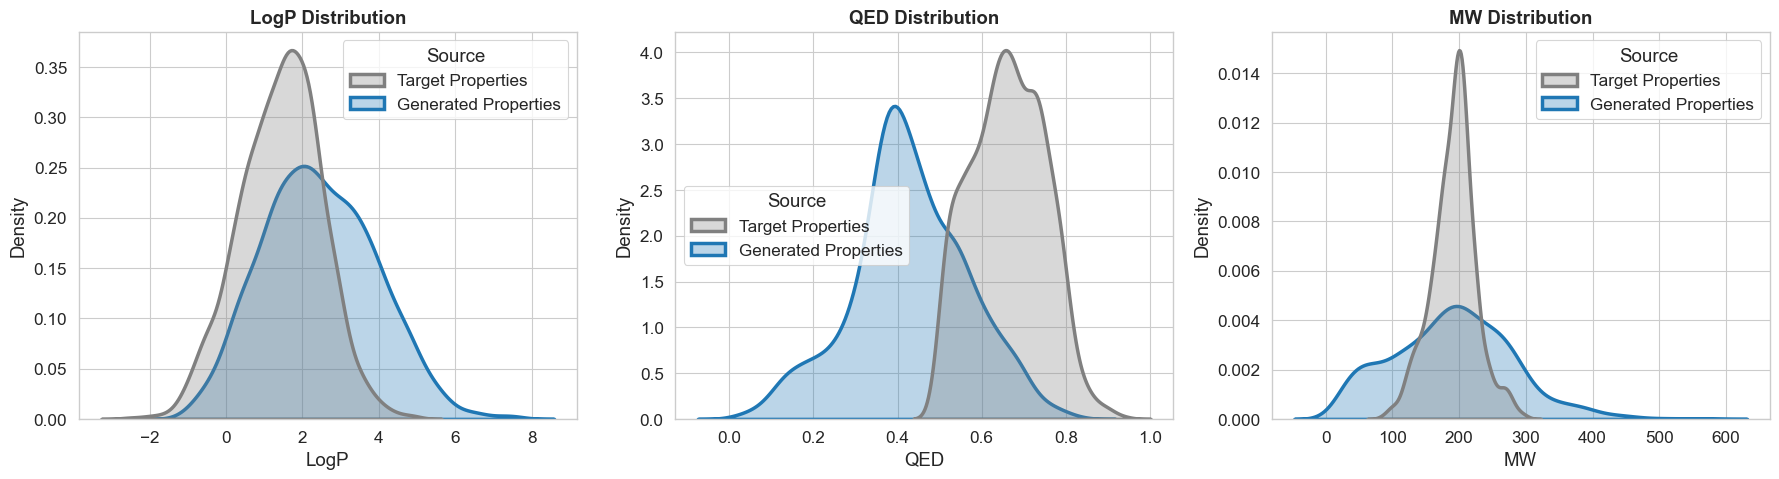

In [30]:
# Get Target Properties and DE-NORMALIZE them
RESULTS_PATH = f"../generation/final_results_AQC_{N_MOLECS}_{TIMESTAMP}.csv"
results_df = pd.read_csv(RESULTS_PATH)

gen_props_df, valid_indices = calculate_generated_properties(results_df)
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()

# Apply de-normalization (using the min/max values from your load_molecules.ipynb)
# You need to make sure min_logp, max_logp, etc. are available here!
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Target Properties'

combined_df = pd.concat([test_props_df, gen_props_df], axis=0) 

# Plot
plot_property_distributions(combined_df)

-------- 10k molect, temperaure = 0.9
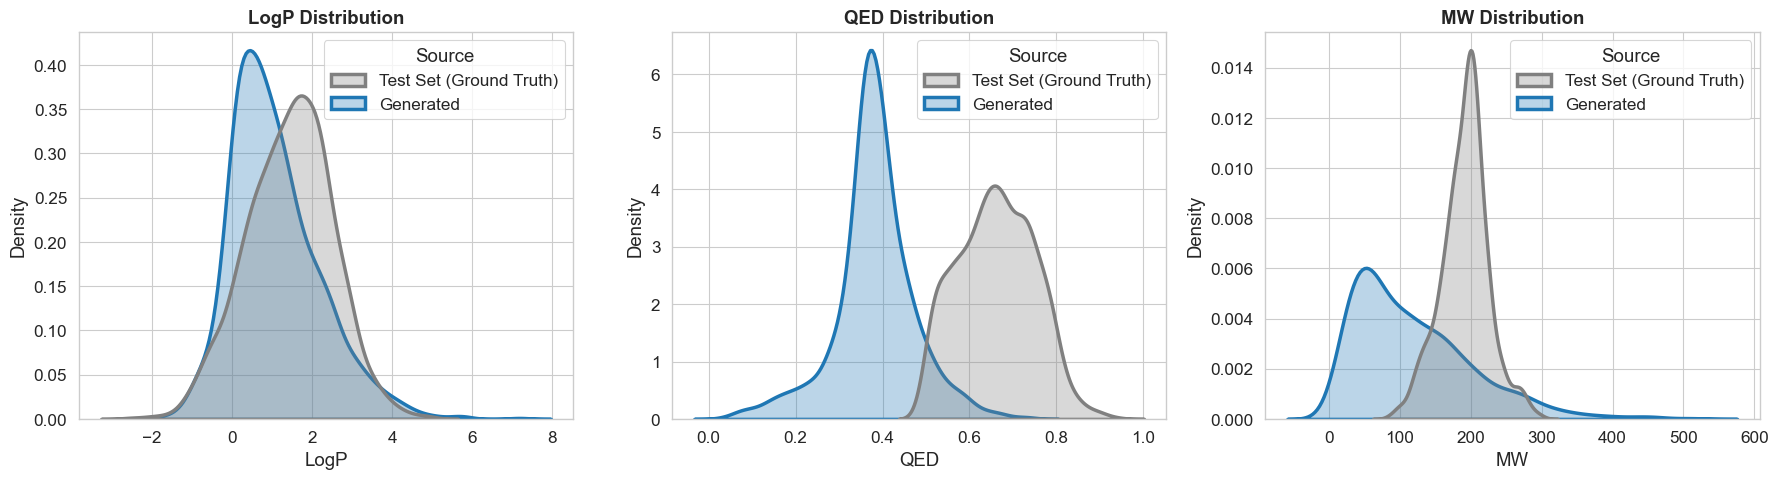

------------------------------------------------------------------

## Stochastic Generation with Tempering

To generate novel molecules, we run the trained model autoregressively.
* **Tempering:** We apply a temperature factor $T$ to the logits ($p_i = \frac{\exp(z_i/T)}{\sum \exp(z_j/T)}$) to control the diversity of the output.
* **Masking:** We explicitly mask invalid start/pad tokens to ensure the generator produces syntactically valid sequences.

Generating 70 candidates using AGC Model...
Target: LogP=2.5, QED=0.8, MW=350.0

--------------------------------------------------------------------------------
AGC RESULTS FOR TARGET: [2.5, 0.8, 350.0]
--------------------------------------------------------------------------------

RANK 1 (Error: 2.5429)
  SMILES: C1C(C)(C)C([H])(CC#N)CP#C[PH1]=P[NH1]1
  PROPERTIES: LogP=3.20 | QED=0.72 | MW=245

RANK 2 (Error: 3.4223)
  SMILES: CCCCC(C)CCCC1CCCOS=N1
  PROPERTIES: LogP=4.08 | QED=0.67 | MW=245

RANK 3 (Error: 3.8492)
  SMILES: CC(C)C(C)CCCCOCC1=C[NH1]C=N1
  PROPERTIES: LogP=3.39 | QED=0.69 | MW=224

Generating SVG visualization...
Saved to: ../generation/aqc_top_candidates_1769092171.svg


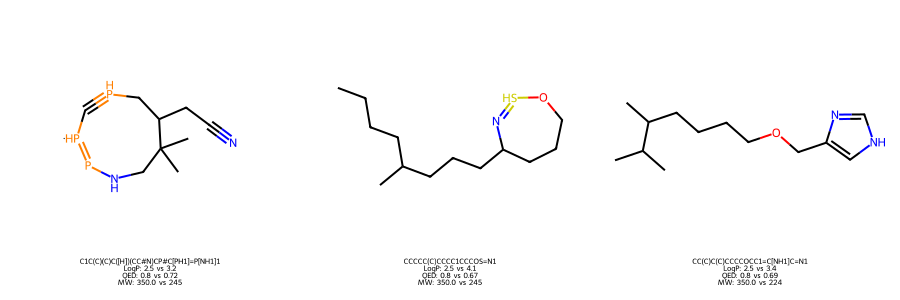

In [57]:
def get_actual_properties(mol):
    """Calculates LogP, QED, MW for an RDKit molecule."""
    if mol is None: return None
    return np.array([
        Descriptors.MolLogP(mol),
        QED.qed(mol),
        Descriptors.ExactMolWt(mol)
    ])

# --- 2. AGC Generation & Ranking Function ---
def generate_and_rank_AGC(target_vals, params, metadata, num_candidates=10, temperature=0.7):
    """
    Generates molecules using the AGC model, calculates ACTUAL properties,
    and ranks them by how close they are to the target.
    """
    # Unpack metadata for cleaner access
    min_logp, max_logp = metadata['min_logP'], metadata['max_logP']
    min_qed,  max_qed  = metadata['min_qed'],  metadata['max_qed']
    min_mw,   max_mw   = metadata['min_mw'],   metadata['max_mw']

    # 1. Normalize Targets (Raw -> [0, pi])
    # The AGC model expects these normalized inputs
    target_norm = jnp.array([
        normalize(target_vals[0], min_logp, max_logp),
        normalize(target_vals[1], min_qed,  max_qed),
        normalize(target_vals[2], min_mw,   max_mw)
    ], dtype=jnp.float32)
    
    candidates = []
    
    print(f"Generating {num_candidates} candidates using AGC Model...")
    print(f"Target: LogP={target_vals[0]}, QED={target_vals[1]}, MW={target_vals[2]}")

    # 2. Key Handling
    # Create a batch of keys for reproducibility within this function
    master_key = jax.random.PRNGKey(int(time.time()*1000))
    keys = jax.random.split(master_key, num_candidates)

    # 3. Generation Loop
    for i in range(num_candidates):
        rng_i = keys[i]
        
        # --- A. AGC Generation Call ---
        # Using your specific function signature
        generated_bits = molecule_stochastic_generation(
            rng_i, 
            target_norm, # Pass the normalized properties array
            params, 
            temperature=temperature
        )
        
        # --- B. Decode Bits -> SMILES ---
        # Using your specific helper
        gen_selfies, gen_smiles = bits_to_selfies_smiles(generated_bits)
        
        # --- C. Validate & Evaluate ---
        mol = Chem.MolFromSmiles(gen_smiles) if gen_smiles else None
        
        if mol:
            # Calculate ACTUAL properties of the generated structure
            act_props = get_actual_properties(mol) # [LogP, QED, MW]
            
            # Normalize Actuals to compare fairly
            act_norm = np.array([
                normalize(act_props[0], min_logp, max_logp),
                normalize(act_props[1], min_qed,  max_qed),
                normalize(act_props[2], min_mw,   max_mw)
            ])
            
            # Error = Squared Distance in Normalized Space
            error = np.sum((target_norm - act_norm)**2)
            
            candidates.append({
                'SMILES': gen_smiles,
                'SELFIES': gen_selfies,
                'LogP': act_props[0], 'QED': act_props[1], 'MW': act_props[2],
                'Error': error,
                'Mol': mol
            })

    # 4. Rank by Lowest Error
    return sorted(candidates, key=lambda x: x['Error'])

# --- 3. Run & Visualize ---

# A. Setup Metadata (Pack your globals if not already packed)
# Assuming you have min_logp, max_logp etc. defined in your notebook
metadata_AGC = {
    'min_logP': min_logp, 'max_logP': max_logp,
    'min_qed':  min_qed,  'max_qed':  max_qed,
    'min_mw':   min_mw,   'max_mw':   max_mw
}

# B. Define Targets
target_values = [2.5, 0.8, 350.0] # [LogP, QED, MW]

# C. Generate
top_AGC = generate_and_rank_AGC(
    target_values, 
    combined_params, # Trained AGC params
    metadata_AGC, 
    num_candidates=70, # Generate 50 to find good ones
    temperature=0.7
)

# D. Print & Draw Top 3
top_3_AGC = top_AGC[:3]

print(f"\n{'-'*80}")
print(f"AGC RESULTS FOR TARGET: {target_values}")
print(f"{'-'*80}")

if not top_3_AGC:
    print("No valid molecules found.")
else:
    legends = []
    for i, cand in enumerate(top_3_AGC):
        print(f"\nRANK {i+1} (Error: {cand['Error']:.4f})")
        print(f"  SMILES: {cand['SMILES']}")
        print(f"  PROPERTIES: LogP={cand['LogP']:.2f} | QED={cand['QED']:.2f} | MW={cand['MW']:.0f}")
        
        # Create Label for Image
        lbl = (f"{cand['SMILES']}\n" 
               f"LogP: {target_values[0]} vs {cand['LogP']:.1f}\n"
               f"QED: {target_values[1]} vs {cand['QED']:.2f}\n"
               f"MW: {target_values[2]} vs {cand['MW']:.0f}")
        legends.append(lbl)

    # Generate Grid
    print(f"\nGenerating SVG visualization...")
    grid_res = Draw.MolsToGridImage(
        [c['Mol'] for c in top_3_AGC],
        molsPerRow=3,
        subImgSize=(300, 300),
        legends=legends,
        useSVG=True
    )
    
    # Handle SVG string extraction safely
    svg_str = grid_res.data if hasattr(grid_res, 'data') else grid_res

    # Save
    fname = f"../generation/aqc_top_candidates_{int(time.time())}.svg"
    with open(fname, "w") as f:
        f.write(svg_str)
    print(f"Saved to: {fname}")
    
    # Display
    display(SVG(svg_str))